In [1]:
import sys
import os
sys.path.append('/global/u2/c/caditi97/exatrkx-ctd2020')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from utils_robust import *

In [2]:
def filter_one(vol_id, lay_id, neighbors, volume_ids, layer_ids):
    adj_layers = [[8,4]]
    neighbor_vol_id = volume_ids[neighbors].reshape(-1,1)
    neighbor_lay_id = layer_ids[neighbors].reshape(-1,1)
    vol_lay_ids = np.concatenate((neighbor_vol_id, neighbor_lay_id), axis=1)
    keep_neighbors = (adj_layers[0]==vol_lay_ids).all(axis=1)
#     print("1 adj_layer:", len(keep_neighbors))
    return np.array(neighbors)[keep_neighbors]

In [3]:
def get_one_emb_eff_purity(index, hits, truth, emb_neighbors, only_adjacent=False):
    vol = hits[['volume_id', 'layer_id']].values.T
    hit = hits.iloc[index]
    pid = truth.iloc[index]['particle_id']
    
    # get true neighbors based on particle id
    if pid == 0:
        true_neighbors = []
    else:
        #total hits in that track
        hit_idx = truth[truth['particle_id']==pid]['hit_id']
        true_hits = hits[hits['hit_id'].isin(hit_idx) & (hits['hit_id'] != hit['hit_id'])]
        true_neighbors = true_hits.index.values.astype(int)
        if only_adjacent:
            true_neighbors = filter_one(hit['volume_id'], hit['layer_id'], true_neighbors, vol[0], vol[1])
    
    emb_neighbors = emb_neighbors[index]
    if only_adjacent:
        emb_neighbors = filter_one(hit['volume_id'], hit['layer_id'], emb_neighbors, vol[0], vol[1])
    
    # calculate purity and eff
    n_true_neighbors = sum(map(lambda n : n in true_neighbors, emb_neighbors))
    purity = n_true_neighbors / len(emb_neighbors) if len(emb_neighbors) > 0 else None
    efficiency = n_true_neighbors / len(true_neighbors) if len(true_neighbors) > 0 else None
    return purity, efficiency

In [4]:
def get_emb_eff_purity(hits, truth, emb_neighbors, vol=None, layer=None, only_adjacent=False):
    n_iter = len(hits)
    purity = []
    efficiency = []
    eff_n = []
    for i in tqdm(range(n_iter)):
        seed_hitid = hits.iloc[i]['hit_id']
        seed_hit = hits[hits['hit_id'] == seed_hitid]
        vid = seed_hit['volume_id'].values.astype(int)
        lid = seed_hit['layer_id'].values.astype(int)
        if (vol == vid) and (lid == layer):
            p, eff = get_one_emb_eff_purity(i, hits, truth, emb_neighbors, only_adjacent)
            if p: purity.append(p)
            if eff: efficiency.append(eff)
    return purity, efficiency

In [5]:
def use_filter(hits, neighbors):
    vol = hits[['volume_id', 'layer_id']].values.T

    batch_size = 64
    num_workers = 12 if DEVICE=='cuda' else 0
    dataset = EdgeData(hits[feature_names].values, vol, neighbors)
    loader = DataLoader(dataset,
                        batch_size = batch_size,
                        num_workers = num_workers,
                        collate_fn = my_collate)
    # apply filter model
    idx_pairs, scores = predict_pairs(loader, filter_model, batch_size)
    filter_pairs, _ = apply_filter(idx_pairs, scores, 0.95)
    filter_pairs = [(pair[0], pair[1]) for pair in filter_pairs]
    return idx_pairs, filter_pairs

In [6]:
def get_filter_eff_purity(hits, truth, idx_pairs, fiter_pairs):
    # get true pairs
    true_pairs = []
    truth_np = np.array(truth.values)
    
    with torch.autograd.no_grad():
        for i, pair in tqdm(enumerate(idx_pairs)):
            hit_a = truth_np[pair[0], 1]
            hit_b = truth_np[pair[1], 1]
            if hit_a != 0 and hit_a == hit_b: #compare particle id
                true_pairs.append((pair[0], pair[1]))
    
    # calculate efficiency and purity
    true_pairs_set = frozenset(true_pairs)
    n_true_pairs = sum(map(lambda n : n in true_pairs_set, filter_pairs))
    purity = n_true_pairs / len(filter_pairs)
    efficiency = n_true_pairs / len(true_pairs)
    return purity, efficiency

In [7]:
def get_overall_eff_purity(hits, truth, idx_pairs, filter_pairs):
    vol = hits[['volume_id', 'layer_id']].values.T
    # get true pairs from original dataset
    true_pairs = []
    for pid in tqdm(truth['particle_id'].unique()):
        if pid == 0: continue
        seed_hits = hits[truth['particle_id']==pid].index.values.astype(int)
        for i in seed_hits:
            hit = hits.iloc[i]
            true_neighbors = filter_one_neighborhood(hit['volume_id'], hit['layer_id'], seed_hits, vol[0], vol[1])
            true_pairs += [(i, n) for n in true_neighbors]
    
    # calculate efficiency and purity
    true_pairs_set = frozenset(true_pairs)
    n_true_pairs = sum(map(lambda n : n in true_pairs_set, filter_pairs))
    purity = n_true_pairs / len(filter_pairs)
    efficiency = n_true_pairs / len(true_pairs)
    return purity, efficiency

In [8]:
def get_track_ratio(hits,truth,neighbors,oghits,vol=None,layer=None):
    track_r = []
    diff = []
    
    for idx in tqdm(range(len(neighbors))):
        seed_hitid = hits.iloc[idx]['hit_id']
        og_hitid = oghits.iloc[idx]['hit_id']
        og_hit = oghits[oghits['hit_id'] == og_hitid]
        seed_hit = hits[hits['hit_id'] == seed_hitid]
        vid = seed_hit['volume_id'].values.astype(int)
        lid = seed_hit['layer_id'].values.astype(int)
        
        # select seed hits only in specified volume 
        if (vid == vol) and (lid == layer):
            # check misalignment
            d = seed_hit['x'].values - og_hit['x'].values
            diff.append(statistics.mean(d))
#             print(seed_hit['x'].values)
#             print("diff per seed hit = ", d)
            # inside neighborhood
            hitidx = neighbors[idx]
            hitids = hits.iloc[hitidx]['hit_id'].values
            sel_hits = hits[hits['hit_id'].isin(hitids)]
            selhits_np = np.array(sel_hits.values)
            # get track for seedhit
            pid = truth.iloc[idx]['particle_id']
            whole_track = []
            if pid == 0:
                whole_track = []
            else:
                whole_track = truth[truth['particle_id']==pid]['hit_id']
            track_hits = hits[hits['hit_id'].isin(whole_track) & (hits['hit_id'] != seed_hitid)]
            track_ids = track_hits['hit_id']
            track_in = len(sel_hits[sel_hits['hit_id'].isin(track_ids)])
            total_track = len(whole_track)
            r = track_in/total_track
            track_r.append(r)
            
    print("Diff overall = ", statistics.mean(diff), len(diff))
    #print("mean diff = " + str(statistics.mean(diff)))
    return (statistics.mean(track_r)), len(track_r)

In [9]:
def get_misaligned_stat(event_path,mcm,vol,layer,filter_one=False):
    e_eff = []
    e_purity = []
    track_r_avg = []
    diff=[]
    og_event_name = "event000009900.pickle"
    oghits, ogtruth, ogemb_model, ogfilter_model = get_data(og_event_name,event_path,None)
    
    for i,mc in enumerate(mcm):
        miss = []
        print("----------")
        event_name = "event000009900_8_" +mc+ ".pickle"
        print(event_name)
        hits, truth, emb_model, filter_model = get_data(event_name,event_path,None)
        print("getting metrics.....")
        neighbors = get_emb_neighbors(hits[feature_names].values, emb_model, 0.4)
        emb_purity, emb_efficiency = get_emb_eff_purity(hits, truth, neighbors, vol, layer,only_adjacent=True)
        print("getting track ratios.....")
        track_r, len_r = get_track_ratio(hits,truth,neighbors,oghits,vol,layer)
        e_eff.append(emb_efficiency)
        e_purity.append(emb_purity)
        track_r_avg.append(track_r)
        
        # checks
        diff.append(misalignment_diff(hits,oghits))
        miss.append(len(hits))
        miss.append(len(neighbors))
        miss.append(len(emb_purity))
        miss.append(len(emb_efficiency))
        miss.append(len_r)
        print("purity = " +str(statistics.mean(emb_purity)))
        print("eff = " +str(statistics.mean(emb_efficiency)))
        print("track ratio = " +str(track_r))
        print("Misalignment = ", diff)
        print("len[Hits,Neighbors,Purity,Efficiency,Track_Ratio] =  ", miss)
   
    return e_eff, e_purity, track_r_avg

In [10]:
def misalignment_diff(mishits,oghits):
    oghits = oghits[oghits['volume_id']==8]
    oghits = oghits[oghits['layer_id']==6]
    mishits = mishits[mishits['volume_id']==8]
    mishits = mishits[mishits['layer_id']==6]
    d = mishits['x']-oghits['x']
    return (statistics.mean(d.values))

In [11]:
def stat_mean(d):
    n = []
    for i in d:
        n.append(statistics.mean(i))
    return n

def stat_round(d):
    n = []
    for i in d:
        n.append(round(i,3))
    return n

In [12]:
# for no ptcut = "/global/cfs/projectdirs/m3443/usr/aoka/data/artifacts/Training_Example_no_ptcut"
# xiangyang's model = "/global/cfs/projectdirs/m3443/usr/dtmurnane/artifacts/adjacent/"
# misaligned data = "/global/cfs/projectdirs/m3443/data/trackml-kaggle/misaligned"
# noise path = f"/global/cfs/cdirs/m3443/usr/aoka/data/classify/Classify_Example_{noise_keep}/preprocess_raw"
artifact_storage_path = "/global/cfs/projectdirs/m3443/usr/dtmurnane/artifacts/adjacent/"
best_emb_path = os.path.join(artifact_storage_path, 'metric_learning_emb', 'best_model.pkl')
best_filter_path = os.path.join(artifact_storage_path, 'metric_learning_filter', 'best_model.pkl') 
event_path = "/global/cfs/projectdirs/m3443/usr/caditi97/exatrkx2020/robust_test/output/misaligned/"
mcm = ["20","100","400","600","800","1000"]
feature_names = ['x', 'y', 'z', 'cell_count', 'cell_val', 'leta', 'lphi', 'lx', 'ly', 'lz', 'geta', 'gphi']

In [13]:
e_eff, e_purity, track_r_avg = get_misaligned_stat(event_path,mcm,8,6,True)

noise: 0, number of hits: 45482
----------
event000009900_8_20.pickle
noise: 0, number of hits: 45482
getting metrics.....


  0%|          | 72/45482 [00:00<01:03, 712.01it/s]

getting track ratios.....


100%|██████████| 45482/45482 [01:26<00:00, 527.78it/s]


Diff overall =  0.019999983 5208
purity = 0.014568218535882574
eff = 0.9987696195796755
track ratio = 0.7764363351488928
Misalignment =  [0.019999983]
len[Hits,Neighbors,Purity,Efficiency,Track_Ratio] =   [45482, 45482, 5012, 5012, 5208]
----------
event000009900_8_100.pickle
noise: 0, number of hits: 45482
getting metrics.....


  0%|          | 70/45482 [00:00<01:04, 699.94it/s]

getting track ratios.....


100%|██████████| 45482/45482 [01:26<00:00, 523.72it/s]


Diff overall =  0.09999999 5208
purity = 0.014566898650630749
eff = 0.9987696195796755
track ratio = 0.7764331349440796
Misalignment =  [0.019999983, 0.09999999]
len[Hits,Neighbors,Purity,Efficiency,Track_Ratio] =   [45482, 45482, 5012, 5012, 5208]
----------
event000009900_8_400.pickle
noise: 0, number of hits: 45482
getting metrics.....


  0%|          | 72/45482 [00:00<01:03, 718.69it/s]

getting track ratios.....


100%|██████████| 45482/45482 [01:26<00:00, 527.57it/s]


Diff overall =  0.4 5208
purity = 0.014573313892450306
eff = 0.9987696195796755
track ratio = 0.7764180141628299
Misalignment =  [0.019999983, 0.09999999, 0.4]
len[Hits,Neighbors,Purity,Efficiency,Track_Ratio] =   [45482, 45482, 5012, 5012, 5208]
----------
event000009900_8_600.pickle
noise: 0, number of hits: 45482
getting metrics.....


  0%|          | 72/45482 [00:00<01:03, 719.72it/s]

getting track ratios.....


100%|██████████| 45482/45482 [01:26<00:00, 524.70it/s]


Diff overall =  0.59999996 5208
purity = 0.01457500416465277
eff = 0.9987696195796755
track ratio = 0.7764272268736554
Misalignment =  [0.019999983, 0.09999999, 0.4, 0.59999996]
len[Hits,Neighbors,Purity,Efficiency,Track_Ratio] =   [45482, 45482, 5012, 5012, 5208]
----------
event000009900_8_800.pickle
noise: 0, number of hits: 45482
getting metrics.....


  0%|          | 70/45482 [00:00<01:05, 690.24it/s]

getting track ratios.....


100%|██████████| 45482/45482 [01:26<00:00, 526.51it/s]


Diff overall =  0.79999995 5208
purity = 0.014574663895791845
eff = 0.9987696195796755
track ratio = 0.7764092564927818
Misalignment =  [0.019999983, 0.09999999, 0.4, 0.59999996, 0.79999995]
len[Hits,Neighbors,Purity,Efficiency,Track_Ratio] =   [45482, 45482, 5012, 5012, 5208]
----------
event000009900_8_1000.pickle
noise: 0, number of hits: 45482
getting metrics.....


  0%|          | 72/45482 [00:00<01:03, 718.22it/s]

getting track ratios.....


100%|██████████| 45482/45482 [01:27<00:00, 520.92it/s]

Diff overall =  1.0 5208
purity = 0.01457632678216468
eff = 0.9986701243433739
track ratio = 0.7762590802481355
Misalignment =  [0.019999983, 0.09999999, 0.4, 0.59999996, 0.79999995, 1.0]
len[Hits,Neighbors,Purity,Efficiency,Track_Ratio] =   [45482, 45482, 5013, 5013, 5208]


In [14]:
# f_e = stat_round(f_eff)
# f_p = stat_round(f_purity)
emb_eff_round = stat_round(stat_mean(e_eff))
emb_purity_round = stat_round(stat_mean(e_purity))

In [15]:
stat_mean(e_purity)

[0.014568218535882574,
 0.014566898650630749,
 0.014573313892450306,
 0.01457500416465277,
 0.014574663895791845,
 0.01457632678216468]

In [16]:
track_r_avg

[0.7764363351488928,
 0.7764331349440796,
 0.7764180141628299,
 0.7764272268736554,
 0.7764092564927818,
 0.7762590802481355]

Text(0, 0.5, 'Efficiency')

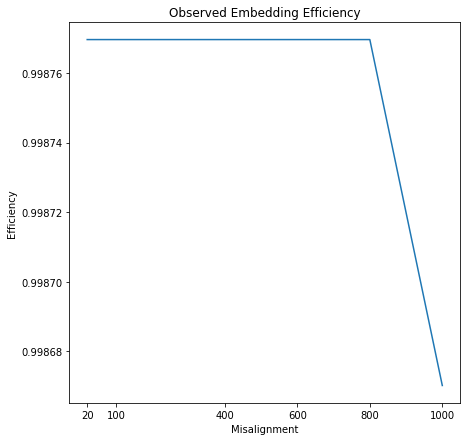

In [17]:
f1, a1 = plt.subplots(figsize=(7,7))
x = [int(m) for m in mcm]
a1.plot(x,stat_mean(e_eff))
a1.set_title("Observed Embedding Efficiency")
a1.set_xticks([20,100,400,600,800,1000])
a1.set_xlabel("Misalignment")
a1.set_ylabel("Efficiency")

Text(0, 0.5, 'Efficiency')

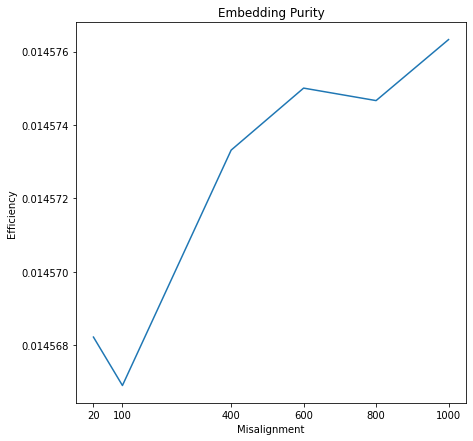

In [18]:
f2, a2 = plt.subplots(figsize=(7,7))
x = [int(m) for m in mcm]
a2.plot(x,stat_mean(e_purity))
a2.set_title("Embedding Purity")
a2.set_xticks([20,100,400,600,800,1000])
a2.set_xlabel("Misalignment")
a2.set_ylabel("Efficiency")

Text(0, 0.5, 'Efficiency')

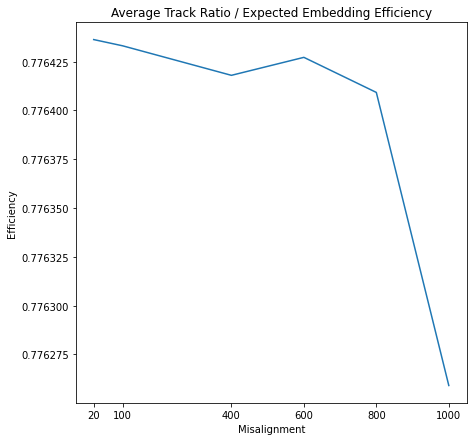

In [19]:
f3, a3 = plt.subplots(figsize=(7,7))
x = [int(m) for m in mcm]
a3.plot(x,track_r_avg)
a3.set_title("Average Track Ratio / Expected Embedding Efficiency")
a3.set_xticks([20,100,400,600,800,1000])
a3.set_xlabel("Misalignment")
a3.set_ylabel("Efficiency")

In [20]:
get_adj_layers(8, 6)[0]

[8, 4]

In [21]:
a = [[8,4]]
a[0]

[8, 4]

In [23]:
original_hits = "event000009900.pickle"
oghits, ogtruth, ogemb_model, ogfilter_model = get_data(original_hits,event_path,None)
print("getting metrics.....")
ogneighbors = get_emb_neighbors(oghits[feature_names].values, ogemb_model, 0.4)
og_emb_purity, og_emb_efficiency = get_emb_eff_purity(oghits, ogtruth, ogneighbors, 8, 6, only_adjacent=True)

print("getting track ratios.....")
og_track_r, og_len_r = get_track_ratio(oghits,ogtruth,ogneighbors,oghits,8,6)


noise: 0, number of hits: 45482
getting metrics.....


  0%|          | 73/45482 [00:00<01:02, 722.22it/s]

getting track ratios.....


100%|██████████| 45482/45482 [01:23<00:00, 544.54it/s]

Diff overall =  0.0 5208


In [24]:
statistics.mean(og_emb_purity)

0.014566794277768448

In [25]:
statistics.mean(og_emb_efficiency)

0.9987696195796755

In [26]:
og_track_r

0.7764363351488928

In [27]:
e0 = np.zeros(len(e_eff)) + statistics.mean(og_emb_efficiency)
obs_eff_loss = e0 - stat_mean(e_eff)

In [28]:
obs_eff_loss

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 9.94952363e-05])

In [30]:
t0 = np.zeros(len(track_r_avg)) + og_track_r
exp_eff_loss = t0 - track_r_avg
exp_eff_loss

array([0.00000000e+00, 3.20020481e-06, 1.83209861e-05, 9.10827524e-06,
       2.70786561e-05, 1.77254901e-04])

In [31]:
loss = e0 - track_r_avg
loss

array([0.22233328, 0.22233648, 0.22235161, 0.22234239, 0.22236036,
       0.22251054])

Text(0, 0.5, 'Loss')

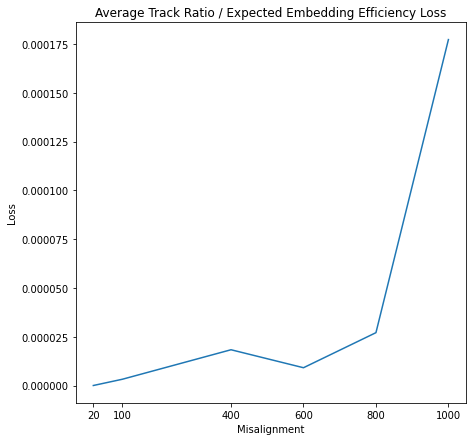

In [32]:
f4, a4 = plt.subplots(figsize=(7,7))
x = [int(m) for m in mcm]
a4.plot(x,exp_eff_loss)
a4.set_title("Average Track Ratio / Expected Embedding Efficiency Loss")
a4.set_xticks([20,100,400,600,800,1000])
a4.set_xlabel("Misalignment")
a4.set_ylabel("Loss")

Text(0, 0.5, 'Loss')

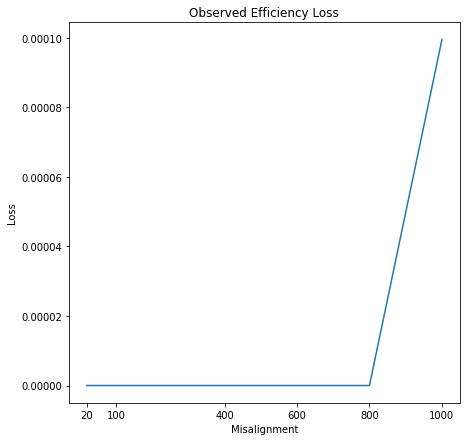

In [33]:
f5, a5 = plt.subplots(figsize=(7,7))
x = [int(m) for m in mcm]
a5.plot(x,obs_eff_loss)
a5.set_title("Observed Efficiency Loss")
a5.set_xticks([20,100,400,600,800,1000])
a5.set_xlabel("Misalignment")
a5.set_ylabel("Loss")

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

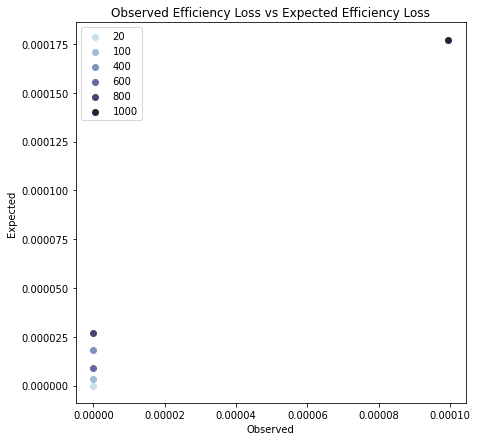

In [39]:
f6, a6 = plt.subplots(figsize=(7,7))
a6.set_xlabel("Observed")
a6.set_ylabel("Expected")
a6.set_title("Observed Efficiency Loss vs Expected Efficiency Loss")
# colors = ("red", "green", "blue", "black", "pink", "yellow")
colors = sns.color_palette("ch:s=.25,rot=-.25", n_colors=6)

for obs,exp,color,mc in zip(obs_eff_loss,exp_eff_loss,colors,mcm):
    a6.scatter(obs,exp,c=color,label=mc)

plt.legend()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

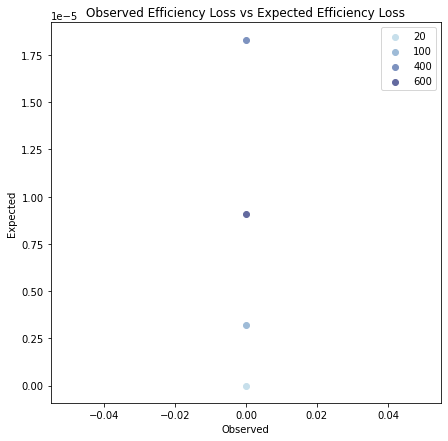

In [42]:
f7, a7 = plt.subplots(figsize=(7,7))
a7.set_xlabel("Observed")
a7.set_ylabel("Expected")
a7.set_title("Observed Efficiency Loss vs Expected Efficiency Loss")
# colors = ("red", "green", "blue", "black", "pink", "yellow")
colors = sns.color_palette("ch:s=.25,rot=-.25", n_colors=6)
colors = colors[:-1].copy()
mcm = mcm[:-1].copy()
obs_eff_loss = obs_eff_loss[:-1].copy()
exp_eff_loss = exp_eff_loss[:-1].copy()

for obs,exp,color,mc in zip(obs_eff_loss,exp_eff_loss,colors,mcm):
    a7.scatter(obs,exp,c=color,label=mc)

plt.legend()